In [1]:
from functools import partial

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision.datasets as dsets
import torchvision.transforms as T
from torchvision.utils import make_grid

from ignite.engine import Engine, Events
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.metrics import Average

import matplotlib.pyplot as plt

from models import DCGAN
from layers import make_discriminator_layers, make_generator_layers
from utils import TabularLogger, TabularOutputHandler

# Data

In [2]:
train_data = dsets.MNIST("./", download=True, transform=T.ToTensor())
train_loader = DataLoader(train_data, batch_size=128)

# Model

In [ ]:
class Generator(nn.Module):
    def __init__(self, dataset: str, latent_dim: int = 100, hidden_channel: int = 128):
        super().__init__()
        self.layers = nn.Sequential(*make_generator_layers(dataset, latent_dim, hidden_channel))
        self.latent_dim = latent_dim

    def forward(self, x):
        return self.layers(x.view(-1, self.latent_dim, 1, 1))


class Discriminator(nn.Module):
    def __init__(self, dataset: str, hidden_channel: int = 128):
        super().__init__()
        self.layers = nn.Sequential(*make_discriminator_layers(dataset, hidden_channel))

    def forward(self, x):
        return self.layers(x).view(-1, 1)

In [ ]:
dataset = "mnist"
generator = Generator(dataset)
discriminator = Discriminator(dataset)

In [ ]:
model = DCGAN(
    generator=generator,
    generator_opt=torch.optim.Adam(generator.parameters()),
    discriminator=discriminator,
    discriminator_opt=torch.optim.Adam(discriminator.parameters()),
)

In [ ]:
_ = model.cuda()

# Trainer

## Set Ignite Engine

In [39]:
trainer = Engine(model.fit_batch)

## Set metrics

In [40]:
def output_transform(output, key):
    return output[key]


for key in ["G_loss", "D_loss"]:
    average = Average(output_transform=partial(output_transform, key=key))
    average.attach(trainer, key)

## Set Progressbar

In [41]:
@trainer.on(Events.EPOCH_COMPLETED(every=1))
def print_every(engine):
    state = f"Epoch {engine.state.epoch} - "
    for key, value in engine.state.metrics.items():
        state += f"{key}: {value:.4f}, "
    print(state)

In [42]:
@trainer.on(Events.EPOCH_COMPLETED(every=1))
def save_img(self, num_img: int = 64) -> None:
    from math import sqrt
    nrow = ncol = sqrt(num_img)
    if nrow * ncol < num_img:
        nrow += 1

    with torch.no_grad():
        model.generator.eval()
        device = next(model.generator.parameters()).device
        z = torch.rand((num_img, model.generator.latent_dim)).to(device)
        fake_data = model.generator(z).cpu()
        fake_data_grid = make_grid(fake_data, int(nrow))
        plt.imshow(fake_data_grid.permute(1,2,0))
        plt.show()

In [43]:
tlogger = TabularLogger()
tlogger.attach(
    trainer, TabularOutputHandler(tag="trainer", metric_names="all"), Events.EPOCH_COMPLETED,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1 - G_loss: 12.6323, D_loss: 0.0182, 


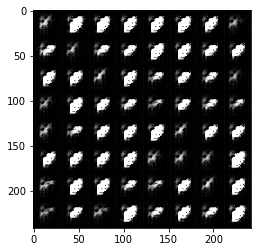

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2 - G_loss: 11.4065, D_loss: 0.0298, 


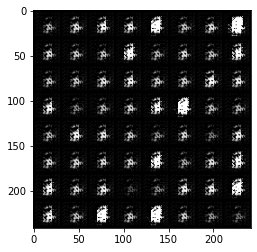

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3 - G_loss: 14.6461, D_loss: 0.0327, 


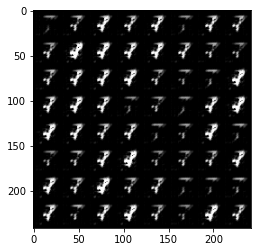

State:
	iteration: 1407
	epoch: 3
	epoch_length: 469
	max_epochs: 3
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [44]:
trainer.run(train_loader, 3)